# Análisis Exploratorio

Importar las librerías

In [ ]:
import pandas as pd
import random
import seaborn as sns
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import matplotlib.lines as mlines
import matplotlib.colors as mcolors
from matplotlib.colors import ListedColormap

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import sklearn.metrics

from scipy import cluster
from scipy.cluster.hierarchy import dendrogram, linkage


#semilla para poder replicar
semilla = 42
np.random.seed(semilla)

In [ ]:
df_train = pd.read_csv("C:\\Users\\User\\Desktop\\TFM\\df_train_generales.csv")
df_test = pd.read_csv("C:\\Users\\User\\Desktop\\TFM\\df_test_generales.csv")

cols_excluidas = ['Name', 'kW Total', 'Month', 'Week', 'WeekDay', 'DailyIndex']
vars_categoricas = ['Tc Error','Rec. low liquid leve']

## Variable objetivo

Visualizamos la distribución de la variable objetivo, que es el consumo.

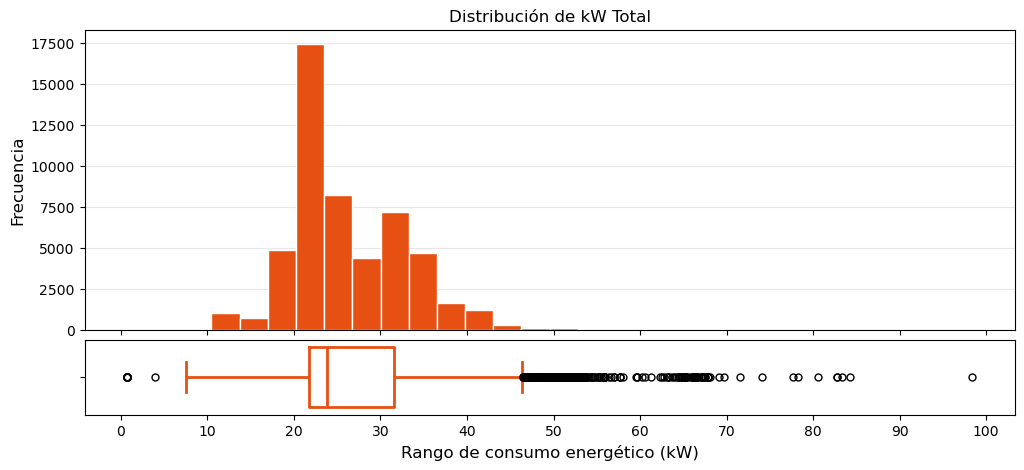

In [ ]:
def histograma_boxplot(ax1, ax2, df, columna, color='#E65113', title='', bins=10): 
    #histograma
    ax1.hist(df[columna], color=color, bins=bins, edgecolor='white')  
    ax1.set_title(title)
    ax1.grid(axis='y', alpha=0.3)
    ax1.set_axisbelow(True)

    #boxplot
    sns.boxplot(x=columna, data=df, ax=ax2,
                vert=False,  #boxplot horizontal
                fill=False,  #no rellenar caja
                linewidth=2,  #grosor de las líneas de caja
                color='#E65113',  #color de las líneas de caja
                flierprops=dict(markeredgecolor='black', marker='o', markersize=5))  #outliers
    #ejes
    ax1.set_ylabel('Frecuencia', size = 12)
    ax2.set_xlabel('Rango de consumo energético (kW)', size=12)
    locator = ticker.MultipleLocator(base=10)  
    ax1.xaxis.set_major_locator(locator)
    ax2.xaxis.set_major_locator(locator)


df_tt = pd.concat([df_train, df_test], axis=0, ignore_index=True)

fig, axes = plt.subplots(figsize=(12, 5), nrows=2, sharex=True, gridspec_kw={'height_ratios': [4, 1], 'hspace': 0.05})

histograma_boxplot(axes[0], axes[1], df_tt, 'kW Total', title='Distribución de kW Total', bins=30)

plt.show()

Analizamos los outliers.

In [ ]:
Q1 = df_tt['kW Total'].quantile(0.25)
Q3 = df_tt['kW Total'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_tt[(df_tt['kW Total'] < lower_bound) | (df_tt['kW Total'] > upper_bound)]
outliers_indices=outliers.index #se utilizará más adelante
num_outliers = len(outliers)

total_obs = len(df_tt)
porcentaje_outliers = (num_outliers / total_obs) * 100

print("Número de outliers en kW Total:", num_outliers)
print("Porcentaje de outliers en kW Total:", round(porcentaje_outliers,2), "%")

Número de outliers en kW Total: 374
Porcentaje de outliers en kW Total: 0.72 %


Visualizamos una semana cualquiera del consumo para ver su variabilidad.

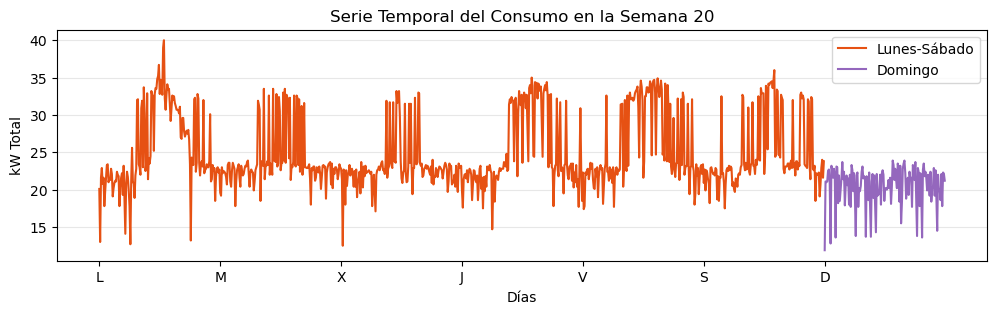

In [ ]:
plt.figure(figsize=(12, 3))
df_week = df_train[df_train['Week']==20]
df_domingos = df_week[df_week['WeekDay'] == 6]
sns.lineplot(data=df_week[df_week['WeekDay'] != 6], x='Name', y='kW Total',color="#E65113", label='Lunes-Sábado')
sns.lineplot(data=df_domingos, x='Name', y='kW Total', color='tab:purple', label='Domingo')

start_date = df_week['Name'].min()
end_date = df_week['Name'].max()
dias_semana = ['L', 'M', 'X', 'J', 'V', 'S', 'D']
plt.xticks(
    ticks=pd.date_range(start=start_date, end=end_date, freq='D'),
    labels=dias_semana)

plt.xlabel('Días')
plt.ylabel('kW Total')
plt.title('Serie Temporal del Consumo en la Semana 20')
plt.grid(axis='y', alpha=0.3)
plt.legend()
plt.show()

Descomponemos la serie de la semana para ver mejor la variabilidad, tendencia y estacionalidad.

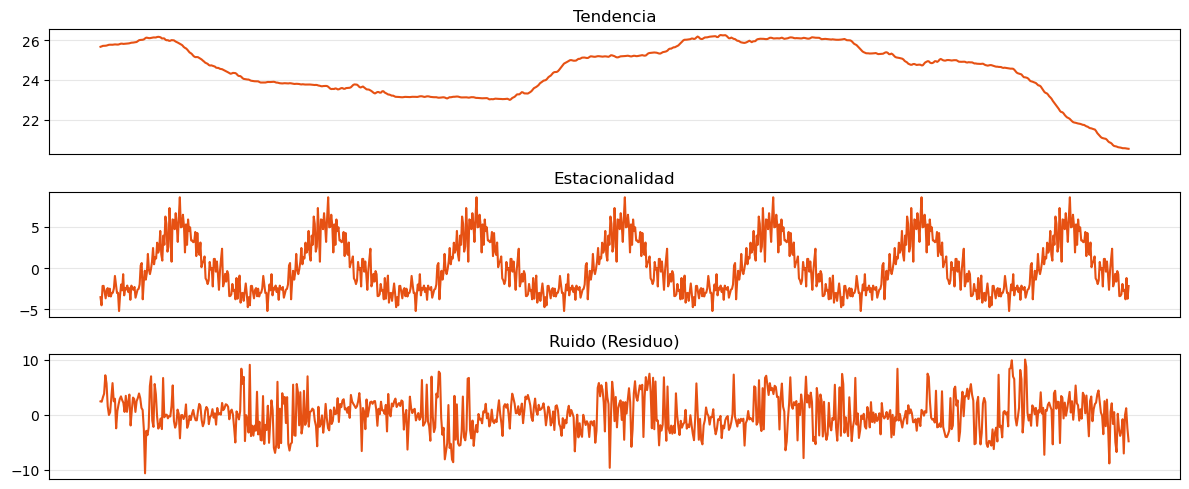

In [ ]:
#descomponer la serie (frecuencia diaria)
decomposition = seasonal_decompose(df_week['kW Total'], period=6*24, model='additive')

#extraer componentes
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


plt.figure(figsize=(12, 5))

#tendencia
plt.subplot(3, 1, 1)
plt.plot(trend, color='#E65113')
plt.title('Tendencia')
plt.xticks([])  
plt.grid(axis='y', alpha=0.3)

#estacionalidad
plt.subplot(3, 1, 2)
plt.plot(seasonal, color='#E65113')
plt.title('Estacionalidad')
plt.xticks([])  
plt.grid(axis='y', alpha=0.3)

#ruido/residuo (variabilidad)
plt.subplot(3, 1, 3)
plt.plot(residual, color='#E65113')
plt.title('Ruido (Residuo)')
plt.xticks([])  
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

Ahora visualizamos el consumo medio diario y cómo es el consumo medio en cada día de la semana.

C:\Users\User\AppData\Local\Temp\ipykernel_7572\1064028986.py:74: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


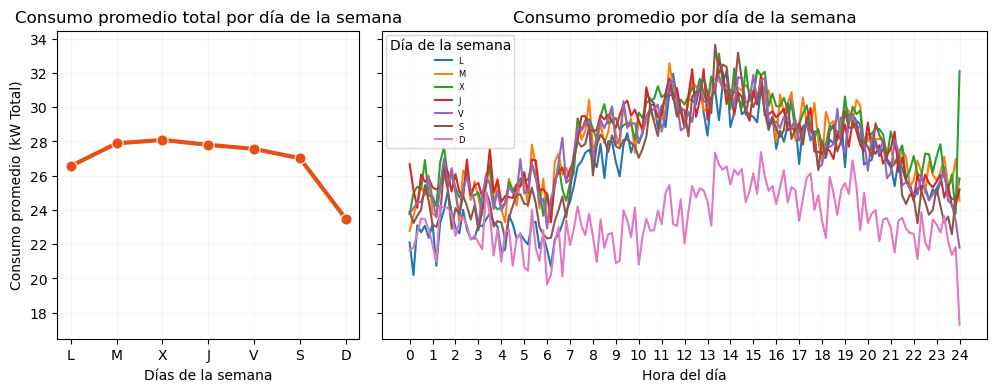

In [ ]:
df_consumo = df_train[['Name', 'kW Total', 'DailyIndex']].copy()

#Por si acaso
df_consumo['Name'] = pd.to_datetime(df_consumo['Name'])
df_consumo['kW Total'] = pd.to_numeric(df_consumo['kW Total'], errors='coerce')

#columna con etiqueta del día de la semana
dias_semana = {0: 'L', 1: 'M', 2: 'X', 3:'J', 4:'V', 5:'S', 6:'D'}
df_consumo['WeekDay'] = df_consumo['Name'].dt.weekday.map(dias_semana)

#calculamos la media del consumo por cada 10 minutos (DailyIndex) y día de la semana
mean_by_hour = df_consumo.groupby(['WeekDay', 'DailyIndex'])['kW Total'].mean().reset_index()

#ordenar los días de la semana 
days_order = ['L','M','X','J','V','S','D']
mean_by_hour['WeekDay'] = pd.Categorical(mean_by_hour['WeekDay'], categories=days_order, ordered=True)

#se calcula la media del consumo por día de la semana mediante df_consumo
mean_by_day = df_consumo.groupby('WeekDay')['kW Total'].mean().reindex(days_order)

#agrupar por mes pero primero se crea la columna 'Month'
df_consumo['Month'] = df_consumo['Name'].dt.month
mean_by_month = df_consumo.groupby('Month')['kW Total'].mean()

#visualizamos dos gráficos que comparten eje Y 
fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharey=True, gridspec_kw={'width_ratios': [1, 2], 'wspace': 0.05})

#1 --> Consumo promedio por día de la semana
sns.lineplot(
    x=mean_by_day.index, 
    y=mean_by_day.values, 
    ax=axs[0], 
    marker='o', 
    color='#E65113', 
    linewidth=3, 
    markersize=8
)
axs[0].set_title('Consumo promedio total por día de la semana')
axs[0].set_xlabel('Días de la semana')
axs[0].set_ylabel('Consumo promedio (kW Total)')
axs[0].grid(True, alpha=0.1)

#2 --> consumo promedio cada 10 minutos según el día de la semana
sns.lineplot(
    ax=axs[1],
    data=mean_by_hour,
    x='DailyIndex',
    y='kW Total',
    hue='WeekDay',
    palette='tab10'
)

#cambiamos ticks del eje X cada 6 valores (6 valores = 1 hora)
min_tick = int(mean_by_hour['DailyIndex'].min())
max_tick = int(mean_by_hour['DailyIndex'].max())
ticks = np.arange(min_tick, max_tick + 1, 6)
tick_labels = (ticks / 6).astype(int)

axs[1].set_xticks(ticks)
axs[1].set_xticklabels(tick_labels)
axs[1].set_xlabel('Hora del día')
axs[1].set_ylabel('Consumo promedio (kW Total)')
axs[1].set_title('Consumo promedio por día de la semana')
axs[1].legend(title='Día de la semana', loc='upper left', fontsize=6)
axs[1].grid(True, alpha=0.1)

plt.tight_layout()
plt.show()


Ahora creamos el gráfico del consumo medio mensual.

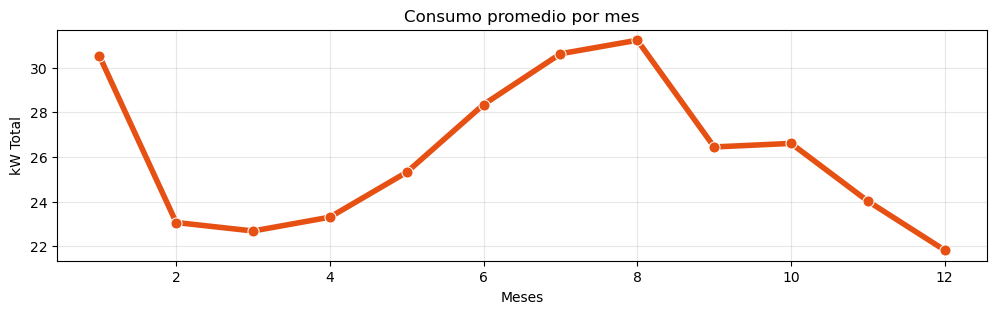

In [ ]:
plt.figure(figsize=(12, 3))
mean_by_month = df_tt.groupby('Month')['kW Total'].mean()
sns.lineplot(data=mean_by_month, marker='o', color='#E65113', linewidth=4, markersize =8)
plt.title('Consumo promedio por mes')
plt.xlabel('Meses')
plt.grid(True, alpha=0.3)

Vamos a crear nuevas variables relacionadas con el día de la semana y la hora de cada día. Utilizamos codificación cíclica en lugar de one hot encoding. https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/

In [ ]:
#convertimos el datetime en segundos
timestamp_train = df_train['Name'].map(pd.Timestamp.timestamp)
timestamp_test = df_test['Name'].map(pd.Timestamp.timestamp)

#cantidad de segundos para cada periodo de tiempo
day = 24*60*60
week = day*7

#transformar usando sin y cos
# tiempo en el día
df_train['Day_sin'] = np.sin(timestamp_train * (2 * np.pi / day))
df_train['Day_cos'] = np.cos(timestamp_train * (2 * np.pi / day))
df_test['Day_sin'] = np.sin(timestamp_test * (2 * np.pi / day))
df_test['Day_cos'] = np.cos(timestamp_test * (2 * np.pi / day))

#tiempo en la semana
df_train['Week_sin'] = np.sin(timestamp_train * (2 * np.pi / week))
df_train['Week_cos'] = np.cos(timestamp_train * (2 * np.pi / week))
df_test['Week_sin'] = np.sin(timestamp_test * (2 * np.pi / week))
df_test['Week_cos'] = np.cos(timestamp_test * (2 * np.pi / week))

vars_temporales = ['Day_sin', 'Day_cos', 'Week_sin', 'Week_cos']

## Variables independientes

### Variables generales del sistema

Visualizamos la distribución de las variables independientes mediante boxplots y mediante barras apiladas para las variables categóricas.

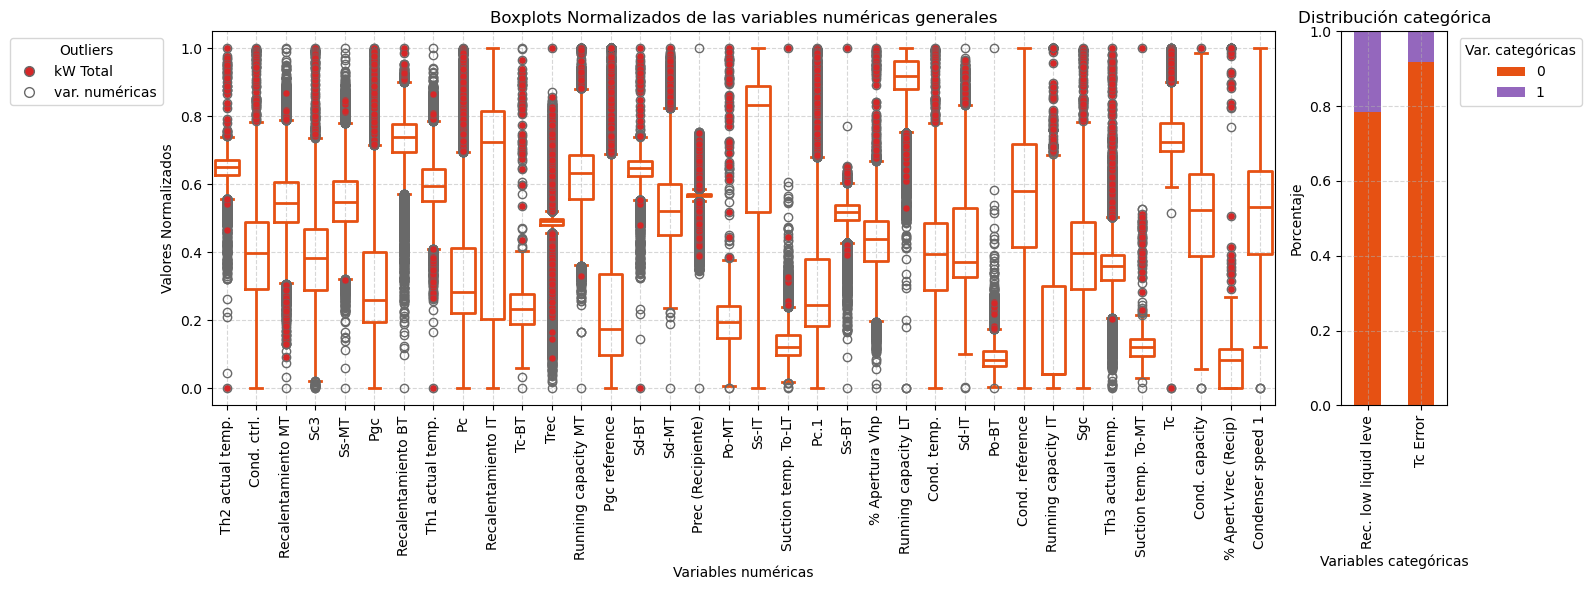

In [ ]:
cmap = ListedColormap(["#E65113","tab:purple"])

#1 --> Gráfico de boxplots

#obtener las variables independientes numéricas
df_for_boxplots = df_train.drop(cols_excluidas + vars_categoricas + vars_temporales, axis=1)

#agregar la columna 'kW_outlier' para comparar (1 si el índice es un outlier en kW Total, sino 0)
df_for_boxplots['kW_outlier'] = df_for_boxplots.index.isin(outliers_indices).astype(int)

#normalizar las columnas numéricas (excluimos 'kW_outlier')
cols_to_normalize = df_for_boxplots.columns.difference(['kW_outlier'])
scaler = MinMaxScaler()
df_for_boxplots[cols_to_normalize] = scaler.fit_transform(df_for_boxplots[cols_to_normalize])

#transformar a formato largo / melt
df_melted = df_for_boxplots.reset_index(drop=True).melt(
    id_vars=['kW_outlier'],
    var_name='Variable',
    value_name='Valor'
)
#excluir la variable 'kW_outlier'
df_melted = df_melted[df_melted['Variable'] != 'kW_outlier']

#función para marcar outliers usando el IQR
def mark_outliers(group):
    Q1 = group['Valor'].quantile(0.25)
    Q3 = group['Valor'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    group['is_outlier'] = (group['Valor'] < lower) | (group['Valor'] > upper)
    return group

df_melted = df_melted.groupby('Variable', group_keys=False).apply(mark_outliers)

#filtramos los outliers que tienen kW_outlier == 1
df_outliers = df_melted[(df_melted['is_outlier']) & (df_melted['kW_outlier'] == 1)]


#2 --> Gráfico de barras apiladas 

#calculamos los porcentajes normalizados de cada categoría
stack_data = {}
for var in vars_categoricas:
    counts = df_tt[var].value_counts(normalize=True)  #porcentajes de cada categoría
    stack_data[var] = counts


#dataframe donde las filas son variables y las columnas las categorías (rellenamos con 0 donde no hay datos).
df_stack = pd.DataFrame(stack_data).T.fillna(0)




fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 6), gridspec_kw={'width_ratios': [10, 1]})

#Subgráfico 1: boxplots
sns.boxplot(
    x='Variable', 
    y='Valor', 
    data=df_melted,
    fill=False,
    color='#E65113',
    flierprops=dict( markeredgecolor='dimgray'),
    width=0.8,
    linewidth=2,
    ax=ax1
)
sns.stripplot(
    x='Variable', 
    y='Valor', 
    data=df_outliers,
    color='tab:red',
    dodge=False,
    jitter=False,  #sin jitter para que se alineen verticalmente
    size=5,
    marker='o',
    edgecolor = 'dimgray',
    facecolor = 'tab:red',
    linewidth=0.3,
    ax=ax1
)
ax1.set_title('Boxplots Normalizados de las variables numéricas generales')
ax1.set_xlabel('Variables numéricas')
ax1.set_ylabel('Valores Normalizados')
ax1.tick_params(axis='x', rotation=90)
ax1.grid(True, linestyle="--", alpha=0.5)
handle_objetivo = mlines.Line2D([], [], color='dimgray', marker='o', linestyle='None',
                                 markersize=7,markerfacecolor='tab:red', label='kW Total')
handle_variables = mlines.Line2D([], [], color='dimgray', marker='o', linestyle='None',
                                 markersize=7,markerfacecolor='none', label='var. numéricas')
ax1.legend(handles=[handle_objetivo, handle_variables], loc='upper right', bbox_to_anchor=(-0.04, 1), title='Outliers')

#Subgráfico 2: barras apiladas 
df_stack.plot(kind='bar', stacked=True, ax=ax2, colormap=cmap, zorder=0)
ax2.set_ylim(0, 1)  #eje Y de 0 a 1
ax2.set_title('Distribución categórica')
ax2.set_xlabel('Variables categóricas')
ax2.set_ylabel('Porcentaje')
ax2.grid(True, linestyle="--", alpha=0.5)
ax2.legend(title="Var. categóricas", bbox_to_anchor=(1.05, 1), loc='upper left')


plt.tight_layout()
plt.show()


Analizamos los outliers de estas variables.

In [ ]:
def calcular_outliers(df):
    for column in df.columns:
        #calculamos los cuartiles y el IQR
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        #contar outliers
        outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
        num_outliers = len(outliers)
        percentage_outliers = (num_outliers / len(df)) * 100

        print(f"Variable: {column}")
        print(f"  Cantidad de outliers: {num_outliers}")
        print(f"  Porcentaje de outliers: {percentage_outliers:.2f}%")
        print("-" * 30)

calcular_outliers(df_train)

Variable: Name
  Cantidad de outliers: 0
  Porcentaje de outliers: 0.00%
------------------------------
Variable: kW Total
  Cantidad de outliers: 339
  Porcentaje de outliers: 0.81%
------------------------------
Variable: Th2 actual temp.
  Cantidad de outliers: 857
  Porcentaje de outliers: 2.05%
------------------------------
Variable: Cond. ctrl.
  Cantidad de outliers: 74
  Porcentaje de outliers: 0.18%
------------------------------
Variable: Recalentamiento MT
  Cantidad de outliers: 700
  Porcentaje de outliers: 1.67%
------------------------------
Variable: Sc3
  Cantidad de outliers: 130
  Porcentaje de outliers: 0.31%
------------------------------
Variable: Ss-MT
  Cantidad de outliers: 574
  Porcentaje de outliers: 1.37%
------------------------------
Variable: Pgc
  Cantidad de outliers: 845
  Porcentaje de outliers: 2.02%
------------------------------
Variable: Recalentamiento BT
  Cantidad de outliers: 1049
  Porcentaje de outliers: 2.51%
-----------------------------

'Trec', 'Prec (Recipiente)' y 'Running capacity LT' muestran bastantes outliers, por lo que vamos a visualizar cada serie en la semana 20 para sacar conclusiones de como tratarlos.

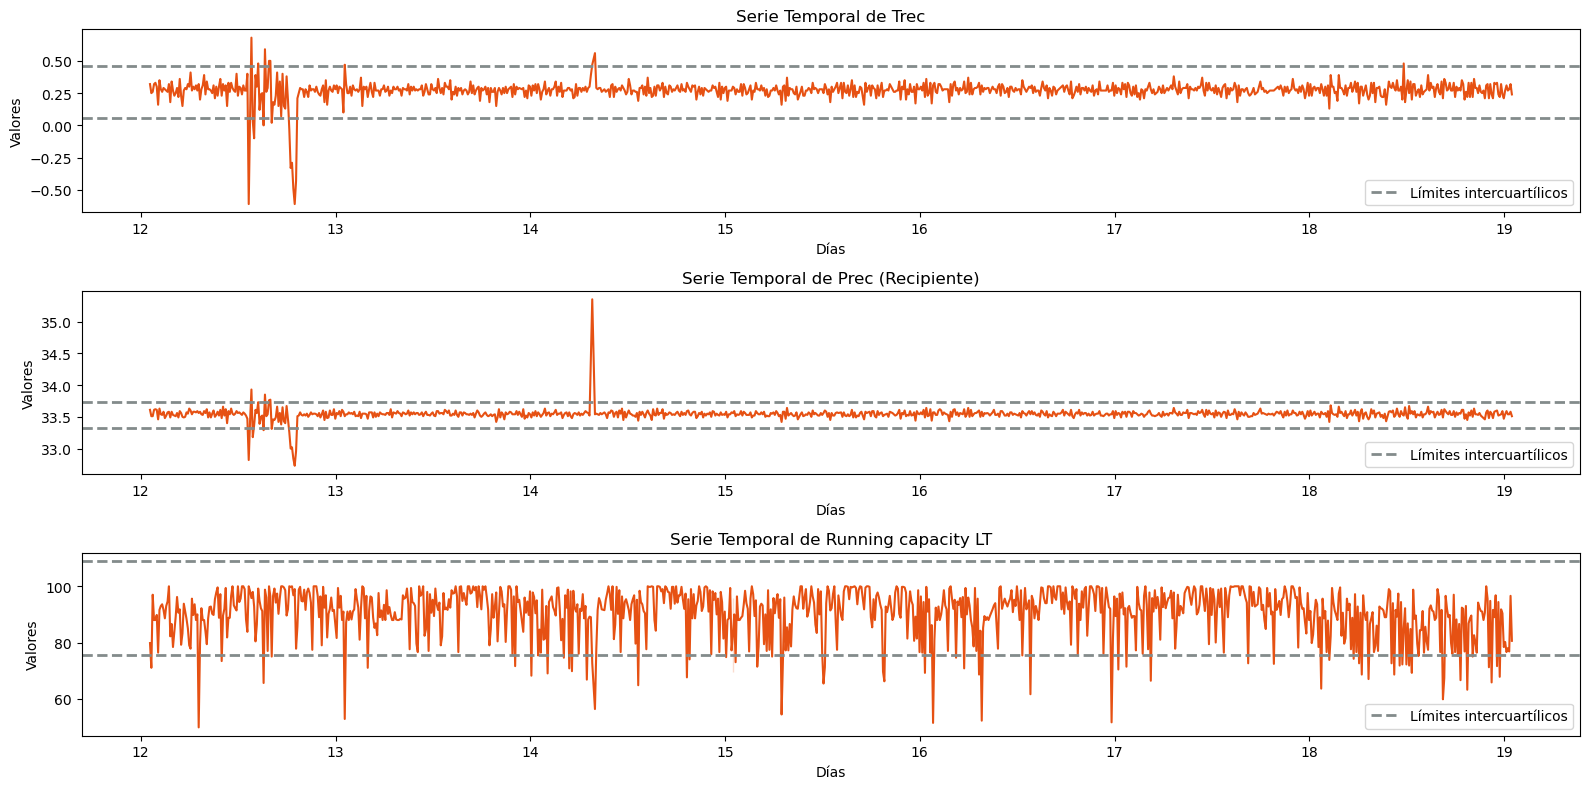

In [ ]:
outliers_cols = ['Trec', 'Prec (Recipiente)', 'Running capacity LT']  #lista de columnas a graficar
fig, axes = plt.subplots(len(outliers_cols), 1, figsize=(16, 8))

axes = axes.flatten()

#calculamos límites intercuartilicos
for i, columna in enumerate(outliers_cols):
    Q1 = df_train[columna].quantile(0.25)
    Q3 = df_train[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = round(Q1 - 1.5 * IQR, 2)
    limite_superior = round(Q3 + 1.5 * IQR, 2)

    
    df_week = df_train[df_train['Week']==20]
    sns.lineplot(data=df_week, x='Name', y=columna, color='#E65113', ax=axes[i])
        
    axes[i].axhline(y=limite_superior, color='#838B8B', linestyle='--', linewidth=2, label=f'Límites intercuartílicos')
    axes[i].axhline(y=limite_inferior, color='#838B8B', linestyle='--', linewidth=2, )

    axes[i].xaxis.set_major_locator(mdates.HourLocator(interval=24))
    axes[i].xaxis.set_major_formatter(mdates.DateFormatter('%d'))

    axes[i].set_xlabel('Días')
    axes[i].set_ylabel('Valores')
    axes[i].set_title(f'Serie Temporal de {columna}')
    axes[i].legend(loc='lower right')

plt.tight_layout()

plt.show()


Solo tratamos los outliers de 'Trec' y 'Prec (Recipiente)' porque los de 'Running capacity LT' son mucho más comunes y no parece que se traten de eventos aislados. En cambio, en 'Trec' y 'Prec (Recipiente)' podemos sustituir los outliers por los valores de los límites ya que además de que parecen ser eventos atípicos, los valores están bastante alejados de estos límites y la diferencia entre los valores atípicos y los típicos se sigue marcando.

In [ ]:
limpieza_cols = ['Trec', 'Prec (Recipiente)']
for columna in limpieza_cols:
    #calcular límites inferior y superior
    Q1 = df_train[columna].quantile(0.25)
    Q3 = df_train[columna].quantile(0.75)
    IQR = Q3 - Q1
    limite_inferior = Q1 - 1.5 * IQR
    limite_superior = Q3 + 1.5 * IQR

    #sustituir outliers por los límites
    df_train[columna] = np.where(
        df_train[columna] < limite_inferior, limite_inferior,
        np.where(df_train[columna] > limite_superior, limite_superior, df_train[columna]))
    
    df_test[columna] = np.where(
        df_test[columna] < limite_inferior, limite_inferior,
        np.where(df_test[columna] > limite_superior, limite_superior, df_test[columna]))

### Variables de refrigeradores

Rescatamos los conjuntos de datos de las variables específicas de los refrigeradores.

In [ ]:
df_train2 = pd.read_csv("C:\\Users\\User\\Desktop\\TFM\\df_train_refrigeradores.csv")
df_test2 = pd.read_csv("C:\\Users\\User\\Desktop\\TFM\\df_test_refrigeradores.csv")
df_tt2 = pd.concat([df_train2, df_test2], axis=0, ignore_index=True)

Analizamos sus distribuciones mediante la visualización de los boxplots.

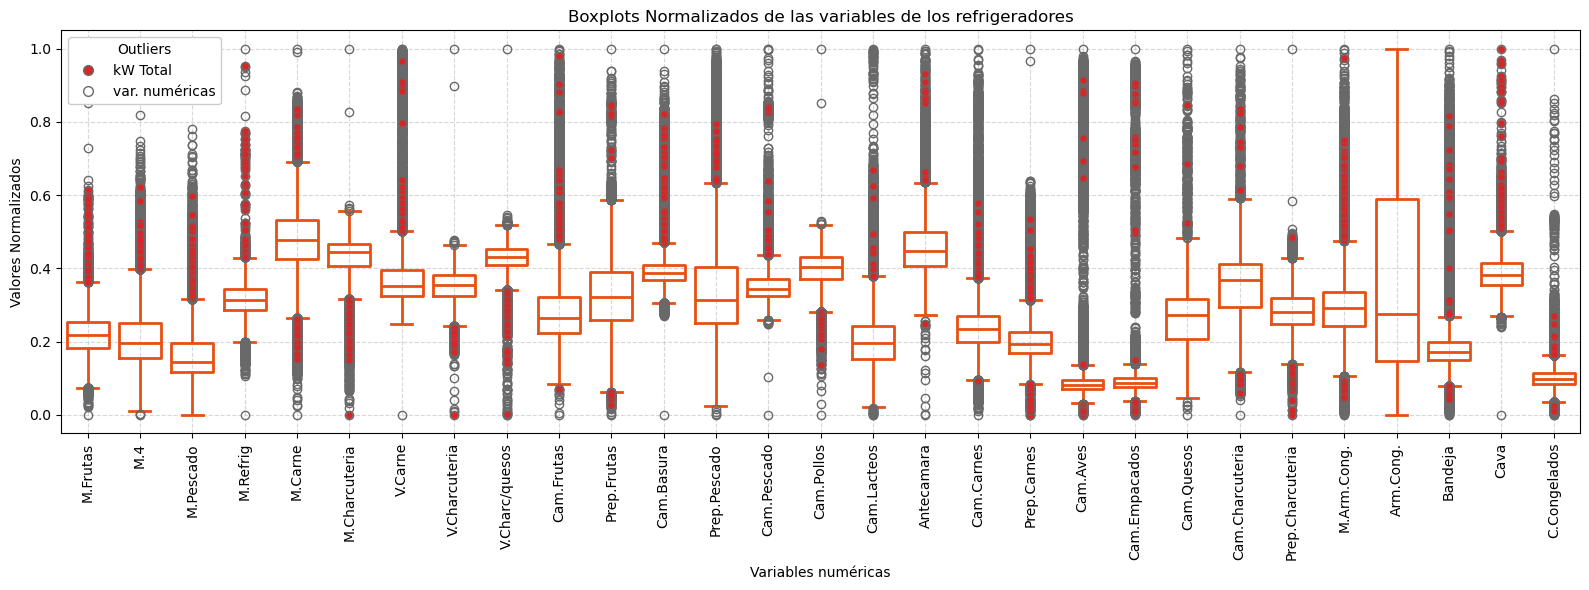

In [ ]:
#hacemos una copia
df_for_boxplots = df_train2.copy()

#crear columna 'kW_outlier': 1 si el índice es un outlier en kW Total, sino 0 
df_for_boxplots['kW_outlier'] = df_for_boxplots.index.isin(outliers_indices).astype(int)

#normalizar las columnas (excluyendo 'kW_outlier')
cols_to_normalize = df_for_boxplots.columns.difference(['kW_outlier'])
scaler = MinMaxScaler()
df_for_boxplots[cols_to_normalize] = scaler.fit_transform(df_for_boxplots[cols_to_normalize])

#transformamos a formato largo/melt
df_melted = df_for_boxplots.reset_index(drop=True).melt(
    id_vars=['kW_outlier'],
    var_name='Variable',
    value_name='Valor'
)
#quitar variable 'kW_outlier' 
df_melted = df_melted[df_melted['Variable'] != 'kW_outlier']

#función para marcar outliers usando IQR
def mark_outliers(group):
    Q1 = group['Valor'].quantile(0.25)
    Q3 = group['Valor'].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    group['is_outlier'] = (group['Valor'] < lower) | (group['Valor'] > upper)
    return group

df_melted = df_melted.groupby('Variable', group_keys=False).apply(mark_outliers)

#filtrar los outliers que tienen kW_outlier == 1
df_outliers = df_melted[(df_melted['is_outlier']) & (df_melted['kW_outlier'] == 1)]


#gráfico de boxplots
plt.figure( figsize=(16, 6))

sns.boxplot(
    x='Variable', 
    y='Valor', 
    data=df_melted,
    fill=False,
    color='#E65113',
    flierprops=dict( markeredgecolor='dimgray'),
    width=0.8,
    linewidth=2)

sns.stripplot(
    x='Variable', 
    y='Valor', 
    data=df_outliers,
    color='tab:red',
    dodge=False,
    jitter=False,  #sin jitter para que se alineen verticalmente
    size=5,
    marker='o',
    edgecolor = 'dimgray',
    facecolor = 'tab:red',
    linewidth=0.3)

plt.title('Boxplots Normalizados de las variables de los refrigeradores')
plt.xlabel('Variables numéricas')
plt.ylabel('Valores Normalizados')
plt.tick_params(axis='x', rotation=90)
plt.grid(True, linestyle="--", alpha=0.5)
handle_objetivo = mlines.Line2D([], [], color='dimgray', marker='o', linestyle='None',
                                 markersize=7,markerfacecolor='tab:red', label='kW Total')
handle_variables = mlines.Line2D([], [], color='dimgray', marker='o', linestyle='None',
                                 markersize=7,markerfacecolor='none', label='var. numéricas')
plt.legend(handles=[handle_objetivo, handle_variables], loc='upper left', bbox_to_anchor=(0, 1), title='Outliers', framealpha=1)


plt.tight_layout()
plt.show()


Analizamos los outliers

In [ ]:
calcular_outliers(df_train2)


Variable: M.Frutas
  Cantidad de outliers: 672
  Porcentaje de outliers: 1.61%
------------------------------
Variable: M.4
  Cantidad de outliers: 3179
  Porcentaje de outliers: 7.60%
------------------------------
Variable: M.Pescado
  Cantidad de outliers: 5087
  Porcentaje de outliers: 12.16%
------------------------------
Variable: M.Refrig
  Cantidad de outliers: 570
  Porcentaje de outliers: 1.36%
------------------------------
Variable: M.Carne
  Cantidad de outliers: 6327
  Porcentaje de outliers: 15.13%
------------------------------
Variable: M.Charcuteria
  Cantidad de outliers: 4915
  Porcentaje de outliers: 11.75%
------------------------------
Variable: V.Carne
  Cantidad de outliers: 2404
  Porcentaje de outliers: 5.75%
------------------------------
Variable: V.Charcuteria
  Cantidad de outliers: 1228
  Porcentaje de outliers: 2.94%
------------------------------
Variable: V.Charc/quesos
  Cantidad de outliers: 2805
  Porcentaje de outliers: 6.71%
---------------------

No tratamos los outliers ya que son variables que estas variables ya han perdido bastante información y tratarlos haría que se eprdiera todavía más información.

## Analisis Bivariante

Juntamos ambos conjuntos (variables generales y específicas de refrigeradores)

In [ ]:
train = pd.concat([df_train, df_train2], axis=1)
test = pd.concat([df_test, df_test2], axis=1)

Analizamos correlaciones.

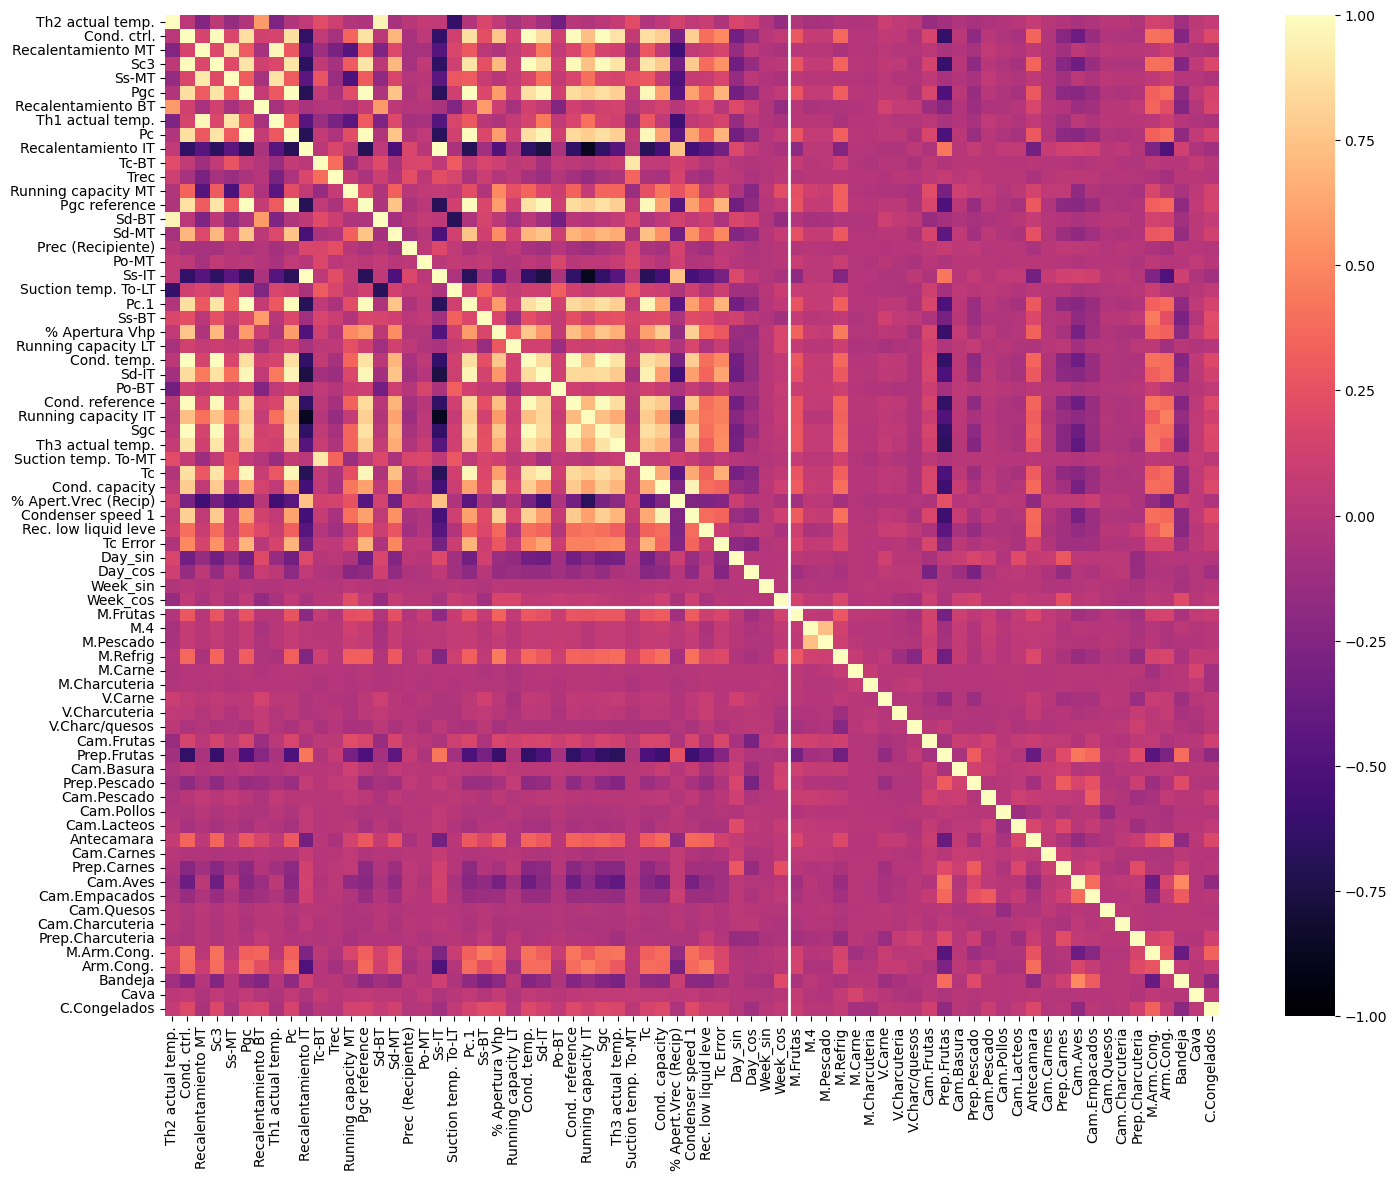

In [ ]:
df_cor = train.drop(['kW Total', 'Name', 'Month','Week','DailyIndex','WeekDay'], axis=1)
cor_matrix = df_cor.iloc[:,:].corr()

plt.figure(figsize=(17, 13))  
ax = sns.heatmap(cor_matrix, vmin=-1, vmax=1, cmap='magma', annot=False)

#añadimos para separar cada grupo de variables independientes en líneas horizontales y verticales
ax.axhline(y=len(cor_matrix)/1.69, color='white', linewidth=2)  
ax.axvline(x=len(cor_matrix.columns)/1.69, color='white', linewidth=2)  

plt.show()

Así como en las variables generales hay correlaciones fuertes, en las de refrigeradores no las hay, excepto por 'M.4' y 'M.Pescado'. Vamos a ver qué correlación tienen.

In [ ]:
correlacion = df_train2['M.4'].corr(df_train2['M.Pescado'])
correlacion

0.7343683527499129

Ahora vamos a analizar las correlaciones que tienen las variables independientes con la variable objetivo.

C:\Users\User\AppData\Local\Temp\ipykernel_16292\3471231184.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlaciones.index, y=abs(correlaciones.values), palette=bar_colors)


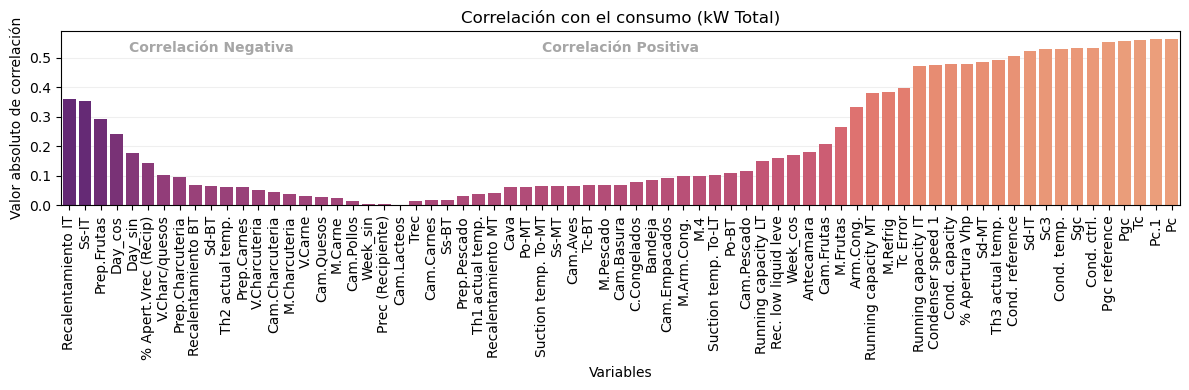

In [ ]:
correlaciones = df_cor.corrwith(df_train['kW Total'])

#ordenamos las correlaciones de menor a mayor
correlaciones = correlaciones.sort_values()

norm = mcolors.Normalize(vmin=-1, vmax=1)
cmap = plt.get_cmap("magma")
bar_colors = [cmap(norm(val)) for val in correlaciones.values]

#figura
plt.figure(figsize=(12, 4))

#barplot horizontal
sns.barplot(x=correlaciones.index, y=abs(correlaciones.values), palette=bar_colors)
plt.annotate('Correlación Negativa', xy=(9,0.51), color='gray',
              ha='center', va='bottom', fontsize=10, fontweight='bold', alpha=0.7)
plt.annotate('Correlación Positiva', xy=(35,0.51), color='gray',
              ha='center', va='bottom', fontsize=10, fontweight='bold', alpha=0.7)
plt.title("Correlación con el consumo (kW Total)")
plt.xlabel("Variables")
plt.xticks(rotation=90)
plt.ylabel("Valor absoluto de correlación")
plt.tight_layout()
plt.gca().set_axisbelow(True)
plt.grid(axis='y', alpha=0.2)
plt.show()


Vamos a ver con exactitud la correlación más grande que hay (es decir, la de Pc con kW Total).

In [ ]:
max_corr = np.abs(correlaciones.values.ravel()).max() 
max_corr

0.5632054681540064

Visualizamos en la semana 20 la serie de 'Pc' (variable más correlacionada con el consumo) junto con la del consumo 'kW Total'.

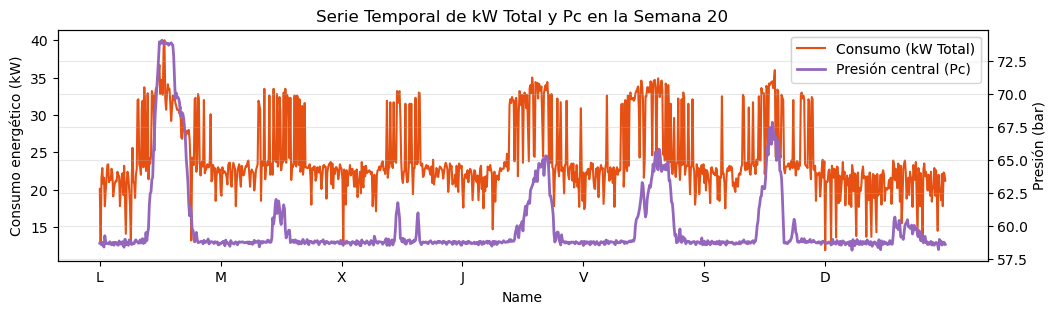

In [ ]:
plt.figure(figsize=(12, 3))

df_week = df_train[df_train['Week'] == 20]

#obtenemos el eje actual
ax1 = plt.gca()  

#graficamos kW Total
sns.lineplot(data=df_week, x='Name', y='kW Total', color="#E65113", label='Consumo (kW Total)', ax=ax1)

#creamos un segundo eje Y
ax2 = ax1.twinx()  

#graficamos Pc
sns.lineplot(data=df_week, x='Name', y='Pc', color='tab:purple', label='Presión central (Pc)',linewidth=2, ax=ax2)

#cambiamos los ticks del eje X
start_date = df_week['Name'].min()
end_date = df_week['Name'].max()
dias_semana = ['L', 'M', 'X', 'J', 'V', 'S', 'D']
plt.xticks(
    ticks=pd.date_range(start=start_date, end=end_date, freq='D'),
    labels=dias_semana)

#adecuamos el plot
plt.xlabel('Días de la semana')
ax1.set_ylabel('Consumo energético (kW)')  #etiqueta eje izquierdo
ax2.set_ylabel('Presión (bar)')  #etiqueta eje derecho
plt.title('Serie Temporal de kW Total y Pc en la Semana 20')
plt.grid(axis='y', alpha=0.3)

#combinamos las leyendas 
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines1 + lines2, labels1 + labels2, loc="upper right")  

plt.show()

Vamos a ver qué variables independientes están prácticamente perfectamente correlacionadas para así reducir dimensionalidad.

In [ ]:
correlaciones = df_train.drop(cols_excluidas, axis=1).corr()
correlaciones_dict = {}
visitadas = set()

for col in correlaciones.columns:
    if col not in visitadas:
        correlacionadas = correlaciones.index[(correlaciones[col] > 0.99) & (correlaciones.index != col)].tolist()
        if correlacionadas:
            correlaciones_dict[col] = correlacionadas
            visitadas.update(correlacionadas)
            visitadas.add(col)

print("Variables con corr = 1:", correlaciones_dict)


Variables con corr = 1: {'Cond. ctrl.': ['Sc3', 'Cond. temp.', 'Sgc'], 'Pgc': ['Pc', 'Pgc reference', 'Pc.1'], 'Recalentamiento IT': ['Ss-IT']}


Reducimos dimensionalidad eliminando variables fuertemente correlacionadas con otras.

In [ ]:
col_elim = ['Cond. ctrl.', 'Cond. temp.', 'Sgc', 'Pgc', 'Pgc reference', 'Pc.1', 'Recalentamiento IT']
df_train = df_train.drop(col_elim, axis=1)
df_test = df_test.drop(col_elim, axis=1)

train = pd.concat([df_train, df_train2], axis=1)
test = pd.concat([df_test, df_test2], axis=1)

Vamos a visualizar ahora las correlaciones entre las variables generales, junto con la magnitud numéricamente.

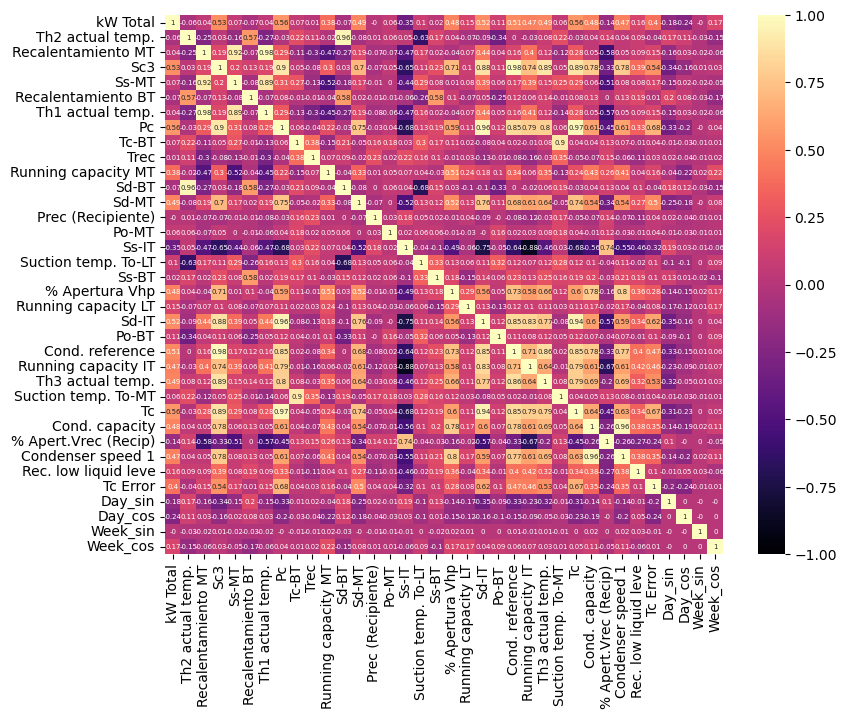

In [ ]:
df_cor = df_train.drop(['Name', 'Month','Week','DailyIndex','WeekDay'], axis=1)
cor_matrix = df_cor.iloc[:,:].corr().round(2)

#crear la matriz de corelación de las variables generales previamente redimensionada
plt.figure(figsize=(9, 7))
sns.heatmap(cor_matrix, vmin=-1, vmax=1, cmap='magma', annot=True, annot_kws={"fontsize": 5})
plt.show()

Vamos a estudair con el dataset transpuesto y mediante PCA la distancia que hay entre las variables para un mejor análisis. Para ello, primero normalizamos el conjunto.

In [ ]:
df_train_excl = df_train.drop(cols_excluidas+vars_temporales, axis=1)
scaler = MinMaxScaler()
train_norm = pd.DataFrame(scaler.fit_transform(df_train_excl), columns = df_train_excl.columns, index = df_train_excl.index)

Visualizamos las distancias y la variabilidad explicada.


Ratio de variabilidad:  [0.702 0.103 0.056 0.039 0.031 0.021 0.016 0.007 0.005 0.004 0.003 0.002
 0.002 0.001 0.001 0.001 0.001 0.001 0.001 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.   ] 


Ratio de variabilidad (PC1 y PC2):  0.80576108897178 



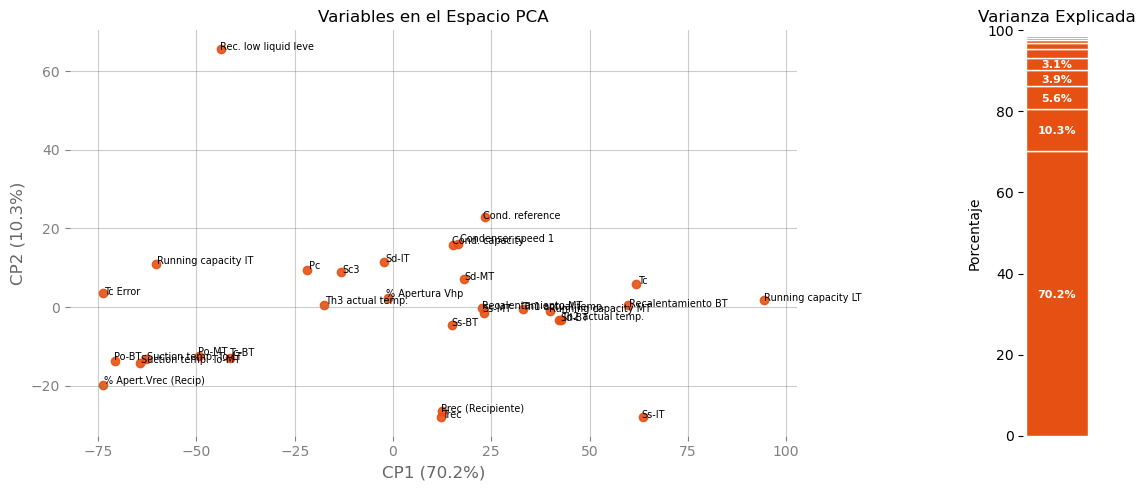

In [ ]:

#transponemos el dataset, así cada variable es una fila
df_feat = train_norm.transpose()
names = df_feat.index

#calculamos el PCA usando tantas componentes como variables
estimator = PCA(n_components=len(names))
X_pca = estimator.fit_transform(df_feat)

#obtenemos varianza explicada
variability_ratio = estimator.explained_variance_ratio_[:2]
pc1_variability = variability_ratio[0] * 100
pc2_variability = variability_ratio[1] * 100

print("\nRatio de variabilidad: ", estimator.explained_variance_ratio_.round(3), "\n")
print("\nRatio de variabilidad (PC1 y PC2): ", sum(variability_ratio), "\n")

#creamos la figura
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5), gridspec_kw={'width_ratios': [15, 1]})

#1 --> scatter plot de PCA
ax1.scatter([x[0] for x in X_pca], [x[1] for x in X_pca], color='#E65113', alpha=0.9)
for i in range(len(X_pca)):
    ax1.text(X_pca[i][0] + (random.random() - 0.5),
             X_pca[i][1] + (random.random() - 0.5),
             names[i], size=7)
ax1.tick_params(axis='x', colors='gray')
ax1.tick_params(axis='y', colors='gray')
ax1.grid(color='gray', alpha=0.4)
ax1.set_frame_on(False)
ax1.set_aspect('equal')
ax1.set_xlabel(f"CP1 ({pc1_variability:.1f}%)", fontsize=12, color='black', alpha=0.6)
ax1.set_ylabel(f"CP2 ({pc2_variability:.1f}%)", fontsize=12, color='black', alpha=0.6)
ax1.set_title("Variables en el Espacio PCA")

#2 --> barra apilada de varianza explicada
total_ratio = estimator.explained_variance_ratio_

bottom = 0
for ratio in total_ratio:
    ax2.bar(0, ratio*100, bottom=bottom, color='#E65113', edgecolor='white', width=0.5)
    #anotamos la var. explicada en el centro de cada bloque (si cabe)
    mid = bottom + ratio*50
    if ratio > 0.03:  # umbral para mostrar la etiqueta
        ax2.text(0, mid-0.3, f"{ratio*100:.1f}%", ha='center', va='center', color='white', fontweight='bold', fontsize=8)
    bottom += ratio*100

#ejes de la barra apilada
ax2.set_ylim(0, 100)
ax2.set_xticks([])  #quitamos etiquetas del eje x
ax2.set_ylabel("Porcentaje")
ax2.set_title("Varianza Explicada")
#ocultar bordes
for spine in ['top', 'right', 'left', 'bottom']:
    ax2.spines[spine].set_visible(False)

plt.tight_layout()
plt.show()


Visualizamos un heatmap de las distancias y un dendograma.

0.9010799500946017


C:\Users\User\AppData\Local\Temp\ipykernel_16292\2534428303.py:30: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  clusters = linkage(matdist, method='single')


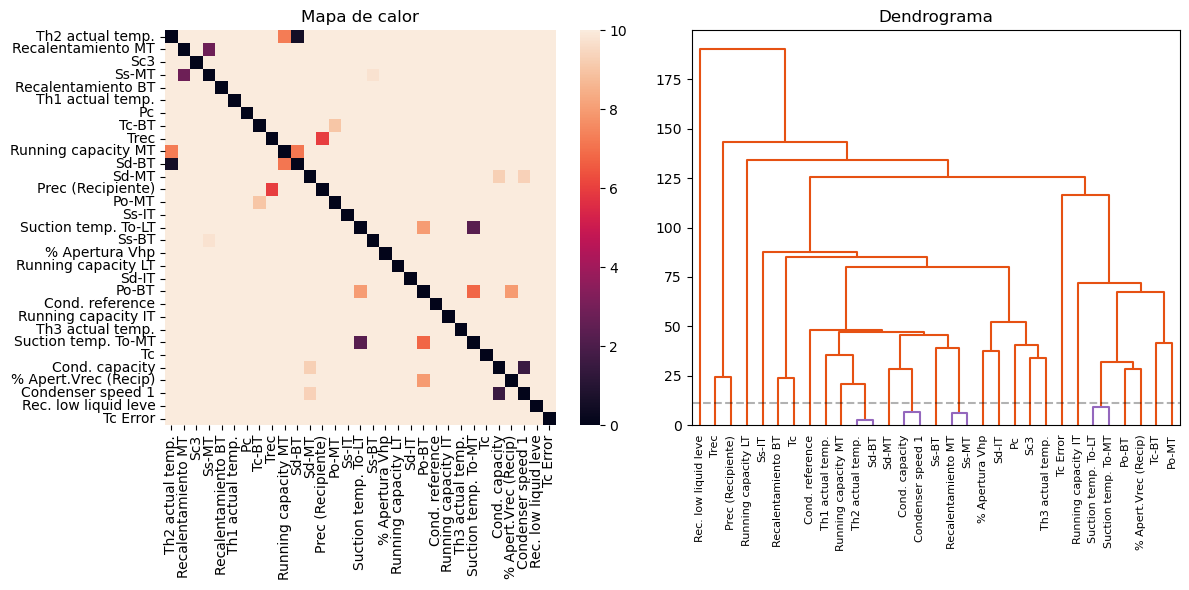

In [ ]:
#función para definir los colores del dendograma
def colores_dendograma(i):
    n = len(df_feat)
    if i < n:
        return 'tab:purple'
    else:
        #accedemos a la fila i - n de la matriz linkage
        if clusters[i - n, 2] > 10:
            return '#E65113'  #color por encima del umbral
        else:
            return 'tab:purple'     

print(sum(estimator.explained_variance_ratio_))
estimator = PCA (n_components = 4)
X_pca = estimator.fit_transform(df_feat)
X_pca = pd.DataFrame(X_pca, index = df_feat.index)
dist = sklearn.metrics.DistanceMetric.get_metric('euclidean')
matdist= dist.pairwise((X_pca))

#crear fgura
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

#Heatmap
sns.heatmap(matdist,vmin=0, vmax = 10, yticklabels = names, xticklabels = names, ax=ax1)
ax1.set_title("Mapa de calor")  

clusters = linkage(matdist, method='single') 

#Dendrograma
dendrogram(clusters, color_threshold=10, labels=df_feat.index, leaf_rotation=90, ax=ax2,
           link_color_func=colores_dendograma )

ax2.set_title("Dendrograma") 
plt.axhline(y=11, color='black', linestyle='--', alpha=0.3)


plt.tight_layout()  
plt.show()

Vamos a volver a ver las variables con mayor correlación para que con toda esta información se decida qué variables escoger y cuales descartar.

In [ ]:
high_corr_pairs = []

#iteramos sobre la matriz 
for i in range(len(cor_matrix.columns)):
    for j in range(i + 1, len(cor_matrix.columns)):  
        col1 = cor_matrix.columns[i]
        col2 = cor_matrix.columns[j]
        correlation = cor_matrix.iloc[i, j]

        if correlation > 0.8:
            high_corr_pairs.append((col1, col2, correlation))

#print de variables con correlación > 0.8
print("Pares de variables con correlación > 0.8:")
for pair in high_corr_pairs:
    print(f"{pair[0]} y {pair[1]}: {pair[2]:.2f}")

Pares de variables con correlación > 0.8:
Th2 actual temp. y Sd-BT: 0.96
Recalentamiento MT y Ss-MT: 0.92
Recalentamiento MT y Th1 actual temp.: 0.98
Sc3 y Pc: 0.90
Sc3 y Sd-IT: 0.88
Sc3 y Cond. reference: 0.98
Sc3 y Th3 actual temp.: 0.89
Sc3 y Tc: 0.89
Ss-MT y Th1 actual temp.: 0.89
Pc y Sd-IT: 0.96
Pc y Cond. reference: 0.85
Pc y Tc: 0.97
Tc-BT y Suction temp. To-MT: 0.90
Sd-IT y Cond. reference: 0.85
Sd-IT y Running capacity IT: 0.83
Sd-IT y Tc: 0.94
Cond. reference y Th3 actual temp.: 0.86
Cond. reference y Tc: 0.85
Cond. capacity y Condenser speed 1: 0.96


In [ ]:
#creamos una copia por si acaso
train_copy = train.copy()
test_copy = test.copy()

Eliminamos variables basándonos en las distancias y correlaciones

In [ ]:
columnas_eliminar = ['Recalentamiento MT', 'Th1 actual temp.', 'Suction temp. To-LT', 'Po-BT',
                      'Cond. capacity', 'Th2 actual temp.', 'Running capacity MT', 'Sc3',
                      'Sd-IT', 'Cond. reference', 'Th3 actual temp.', 'Tc']

train = train.drop(columnas_eliminar, axis=1)
test = test.drop(columnas_eliminar, axis=1)
print('TRAIN: ', train.shape, '\nTEST: ', test.shape)

TRAIN:  (41825, 58) 
TEST:  (10457, 58)


In [ ]:
# train = train_copy.copy()
# test = test_copy.copy()

Eliminamos variables utilizadas para visualización, y también 'Name'.

In [ ]:
train = train.drop(['Name', 'Month', 'Week', 'WeekDay',  'DailyIndex'], axis=1)
test= test.drop(['Name', 'Month', 'Week', 'WeekDay', 'DailyIndex'], axis=1)

In [ ]:
train.shape

(41825, 53)

In [ ]:
train.dropna(inplace=True)
test.dropna(inplace=True)

train.to_csv("C:\\Users\\User\\Desktop\\TFM\\train.csv", index=False)
test.to_csv("C:\\Users\\User\\Desktop\\TFM\\test.csv", index=False)

# Procesado Final

## Feature Selection

Con las variables restantes, aplicamos Random Forest Regression y Gradient Boosting Regression para saber la importancia que tiene cada variable. Para ello primero estandarizamos el dataset.

In [ ]:
#datos separados en entrenamiento y prueba
X_train = train.drop('kW Total', axis=1)
y_train = train['kW Total']
X_test = test.drop('kW Total', axis=1)
y_test = test['kW Total']

#estandarizamos las variables independientes
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random Forest

In [ ]:
X = X_train
y = y_train

#cargamos el algoritmo
rf = RandomForestRegressor(n_estimators=100, random_state=semilla)
rf.fit(X, y)

RandomForestRegressor(random_state=42)

In [ ]:
importancia = rf.feature_importances_
impor_df = pd.DataFrame({'Variable': X.columns, 'Importancia_RFR': importancia}).sort_values(by='Importancia_RFR', ascending=False)

Gradient Boosting

In [ ]:
#cargamos el algoritmo
gbr = GradientBoostingRegressor(n_estimators=100, random_state=semilla)

gbr.fit(X, y)

importancia_gbr = gbr.feature_importances_

importancia_df_gbr = pd.DataFrame({'Variable': X.columns, 'Importancia': importancia_gbr})

#ordenar de mayor a menor según importancia
importancia_df_gbr = importancia_df_gbr.sort_values(by='Importancia', ascending=False)

Visualizamos la importancia de cada variable.

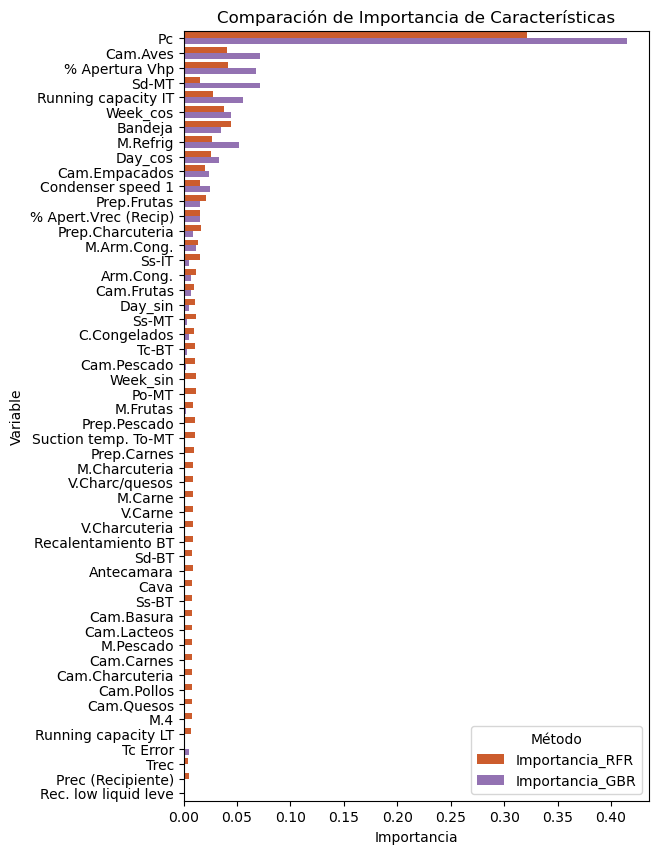

In [ ]:
importancia_gbr = pd.DataFrame({'Variable': X.columns, 'Importancia_GBR': gbr.feature_importances_})

merge_importancia = pd.merge(impor_df, importancia_gbr, on='Variable')

merge_importancia['Media_Importancia'] = merge_importancia[['Importancia_RFR', 'Importancia_GBR']].mean(axis=1)
merge_importancia = merge_importancia.sort_values(by='Media_Importancia', ascending=False)

#columna metodo para poder comparar las importancias según método
merge_importancia = pd.melt(merge_importancia, id_vars=['Variable'], value_vars=['Importancia_RFR', 'Importancia_GBR'],
                             var_name='Método', value_name='Importancia')

plt.figure(figsize=(6, 10))
sns.barplot(x='Importancia', y='Variable', hue='Método', data=merge_importancia, palette=["#E65113","tab:purple"])
plt.title('Comparación de Importancia de Características')
plt.show()

Analizamos las variables seleccionadas y vemos que 'Cam.Aves' y 'Bandeja' no ayudan en la predicción.

In [ ]:
# def plot_train_test(train, test, columnas):

#     num_columnas = len(columnas)
#     fig, axes = plt.subplots(nrows=num_columnas, ncols=1, figsize=(10, 5 * num_columnas))

#     for i, c in enumerate(columnas):
#         #ajustamos el índice de test para que continúe después de train
#         final_ind_train = train.index[-1] + pd.Timedelta(days=1) if isinstance(train.index, pd.DatetimeIndex) else train.index[-1] + 1
#         nuevo_ind_test = test.index + (final_ind_train - test.index[0])
#         test_nuevo = test.copy()
#         test_nuevo.index = nuevo_ind_test

#         axes[i].plot(train.index, train[c], color='red', label='Train')
#         axes[i].plot(test_nuevo.index, test_nuevo[c], color='blue', label='Test')
#         axes[i].set_title(f'Serie Temporal Contigua de {c}')
#         axes[i].set_xlabel('Tiempo')
#         axes[i].set_ylabel(c)
#         axes[i].legend()
#         axes[i].grid(True)

#     plt.tight_layout()
#     plt.show()

# columnas = ['Pc', 'Cam.Aves', '% Apertura Vhp', 'Sd-MT', 'Running capacity IT','Week_cos', 'Bandeja', 'M.Refrig', 'Day_cos']
# plot_train_test(train, test, columnas)

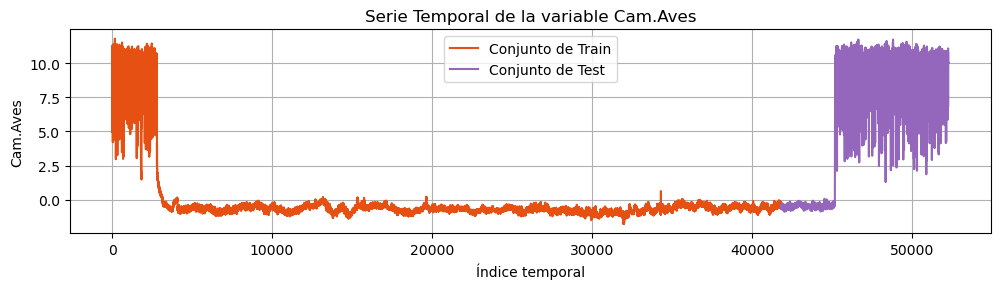

In [ ]:
def plot_train_test(train, test, columna):
    #ajustamos el índice de test para que continúe después de train
    final_ind_train = train.index[-1] + pd.Timedelta(days=1) if isinstance(train.index, pd.DatetimeIndex) else train.index[-1] + 1
    nuevo_ind_test = test.index + (final_ind_train - test.index[0])
    test_nuevo = test.copy()
    test_nuevo.index = nuevo_ind_test

    plt.figure(figsize=(10, 3))
    plt.plot(train.index, train[columna], color='#E65113', label='Conjunto de Train')
    plt.plot(test_nuevo.index, test_nuevo[columna], color='tab:purple', label='Conjunto de Test')
    plt.title(f'Serie Temporal de la variable {columna}')
    plt.xlabel('Índice temporal')
    plt.ylabel(columna)
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

plot_train_test(train, test, 'Cam.Aves')

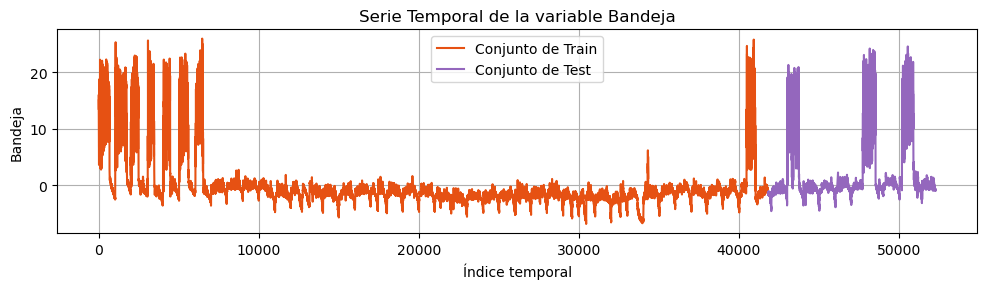

In [ ]:
plot_train_test(train, test, 'Bandeja')

## SUAVIZADO

Suavizamos la variable objetivo

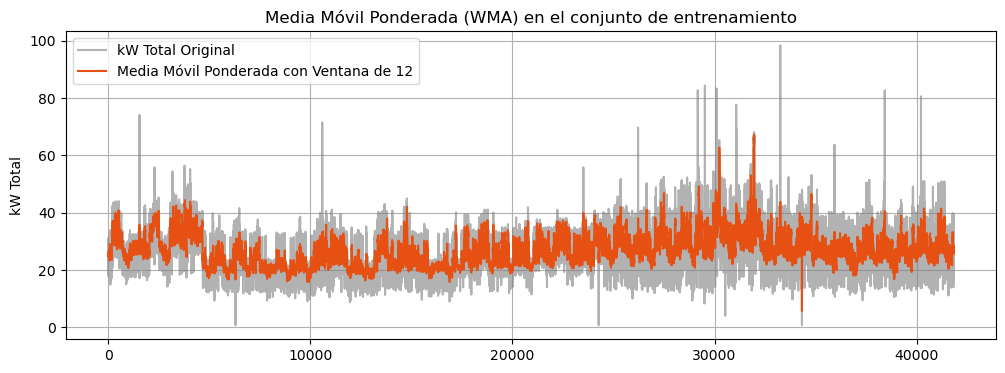

In [ ]:
plt.figure(figsize=(12, 4))

consumo_train =train['kW Total']
consumo_test = test['kW Total']
#pesos
weights = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12])

#WMA
train['kW Total'] = train['kW Total'].rolling(window=12).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)
test['kW Total'] = test['kW Total'].rolling(window=12).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)


plt.plot(consumo_train, label='kW Total Original', color='grey', alpha=0.6)
plt.plot(train['kW Total'], label='Media Móvil Ponderada con Ventana de 12', color='#E65113')

plt.title("Media Móvil Ponderada (WMA) en el conjunto de entrenamiento")
plt.ylabel("kW Total")
plt.grid(True)
plt.legend()

plt.show()

Guardamos los datasets.

In [ ]:

train.to_csv("C:\\Users\\User\\Desktop\\TFM\\train.csv", index=False)
test.to_csv("C:\\Users\\User\\Desktop\\TFM\\test.csv", index=False)